In [1]:
!nvidia-smi

Sat Apr  5 13:25:28 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   34C    P0             28W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import numpy as np

def create_overlapping_sequences(data, window_size=32):
    sequences = []
    for instance in data:
        seqs = [instance[i:i+window_size] for i in range(len(instance) - window_size + 1)]
        sequences.append(np.array(seqs))  # Shape: (num_sequences_per_instance, window_size)
    return np.array(sequences)  # Final shape: (instances, num_sequences, window_size)



def accumulate_episodes(data, signal_type):
    """
    Accumulate episodes from all records into a single dataset, ensuring uniform length.

    Parameters:
    - data (dict): Filtered dataset (e.g., butterworth_data).
    - signal_type (str): Type of signal to accumulate ('filtered_ecg' or 'filtered_abp').

    Returns:
    - accumulated_data (np.array): Array of shape (total_episodes, 625).
    """
    accumulated_data = []

    for record_id in data.keys():  # Loop through each record
        for episode in data[record_id][signal_type]:  # Loop through each 10-second episode
            if len(episode) == 625:  # Ensure the episode has 625 points
                accumulated_data.append(episode)  # Add the episode to the list
            #else:
                #print(f"Skipping episode with invalid length: {len(episode)} (Record: {record_id})")

    return np.array(accumulated_data)  # Convert list to numpy array

In [3]:
import torch
import torch.nn as nn

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = pe.unsqueeze(0)  # Shape: (1, max_len, d_model)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :].to(x.device)
        return x

class TransformerBP(nn.Module):
    def __init__(self, input_dim=1, d_model=64, num_heads=4, num_layers=3, dropout=0.1):
        super(TransformerBP, self).__init__()

        self.input_fc = nn.Linear(input_dim, d_model)  # Project 32 input features to d_model
        self.pos_encoding = PositionalEncoding(d_model)

        encoder_layers = nn.TransformerEncoderLayer(d_model=d_model,
                                                    nhead=num_heads,
                                                    dim_feedforward=4*d_model,
                                                    dropout=dropout,
                                                    batch_first=True)

        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)

        self.output_fc = nn.Linear(d_model, 1)  # Predict 1 BP value per time step

    def forward(self, x):
        x = self.input_fc(x)  # Shape: (batch_size, seq_len=32, d_model)
        x = self.pos_encoding(x)  # Add positional encoding
        x = self.transformer_encoder(x)  # Pass through Transformer Encoder
        x = self.output_fc(x)  # Predict BP value at each time step
        return x

In [4]:
import gdown

file_id = "12KmtjeVHuZP4omk-AvEBpfwmI1cPn1R7"
download_url = f"https://drive.google.com/uc?id={file_id}"
output_file = "butter_maf_dataset.npy"

gdown.download(download_url, output_file, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=12KmtjeVHuZP4omk-AvEBpfwmI1cPn1R7
From (redirected): https://drive.google.com/uc?id=12KmtjeVHuZP4omk-AvEBpfwmI1cPn1R7&confirm=t&uuid=6f796452-e40f-4b66-95c4-0e0fc1abb5ab
To: /kaggle/working/butter_maf_dataset.npy
100%|██████████| 384M/384M [00:03<00:00, 104MB/s]  


'butter_maf_dataset.npy'

In [5]:
bm_data = np.load("butter_maf_dataset.npy", allow_pickle=True).item()

ppg_bm = accumulate_episodes(bm_data, signal_type='filtered_ppg')
ecg_bm = accumulate_episodes(bm_data, signal_type='filtered_ecg')
abp_bm = accumulate_episodes(bm_data, signal_type='filtered_abp')

print(f"Shapes of PPG: {ppg_bm.shape}")
print(f"Shapes of ECG: {ecg_bm.shape}")
print(f"Shapes of ABP: {abp_bm.shape}")

Shapes of PPG: (25319, 625)
Shapes of ECG: (25319, 625)
Shapes of ABP: (25319, 625)


In [6]:
from sklearn.model_selection import train_test_split

abp_train_val, abp_test, ppg_train_val, ppg_test, ecg_train_val, ecg_test = train_test_split(abp_bm, ppg_bm, ecg_bm, test_size=0.2, random_state=42)
abp_train, abp_val, ppg_train, ppg_val, ecg_train, ecg_val = train_test_split(abp_train_val, ppg_train_val, ecg_train_val, test_size=0.2, random_state=42)

print(f"Train shape: {abp_train.shape}")  # ~64% of data
print(f"Validation shape: {abp_val.shape}")  # ~16%
print(f"Test shape: {abp_test.shape}")  # ~20%

Train shape: (16204, 625)
Validation shape: (4051, 625)
Test shape: (5064, 625)


In [7]:
from sklearn.preprocessing import MinMaxScaler

# Initialize scalers
scaler_abp = MinMaxScaler(feature_range=(0, 1))
scaler_ppg = MinMaxScaler(feature_range=(0, 1))
scaler_ecg = MinMaxScaler(feature_range=(0, 1))

# Fit on ALL training data at once (global scaling)
scaler_abp.fit(np.concatenate(abp_train).reshape(-1, 1))
scaler_ppg.fit(np.concatenate(ppg_train).reshape(-1, 1))
scaler_ecg.fit(np.concatenate(ecg_train).reshape(-1, 1))

# Transform each episode without re-fitting
abp_train_scaled = np.array([scaler_abp.transform(episode.reshape(-1, 1)).flatten() for episode in abp_train])
abp_val_scaled = np.array([scaler_abp.transform(episode.reshape(-1, 1)).flatten() for episode in abp_val])
abp_test_scaled = np.array([scaler_abp.transform(episode.reshape(-1, 1)).flatten() for episode in abp_test])

ppg_train_scaled = np.array([scaler_ppg.transform(episode.reshape(-1, 1)).flatten() for episode in ppg_train])
ppg_val_scaled = np.array([scaler_ppg.transform(episode.reshape(-1, 1)).flatten() for episode in ppg_val])
ppg_test_scaled = np.array([scaler_ppg.transform(episode.reshape(-1, 1)).flatten() for episode in ppg_test])

ecg_train_scaled = np.array([scaler_ecg.transform(episode.reshape(-1, 1)).flatten() for episode in ecg_train])
ecg_val_scaled = np.array([scaler_ecg.transform(episode.reshape(-1, 1)).flatten() for episode in ecg_val])
ecg_test_scaled = np.array([scaler_ecg.transform(episode.reshape(-1, 1)).flatten() for episode in ecg_test])

In [8]:
X_train_data = np.stack((ppg_train_scaled, ecg_train_scaled), axis=2)
X_val_data = np.stack((ppg_val_scaled, ecg_val_scaled), axis=2)
X_test_data = np.stack((ppg_test_scaled, ecg_test_scaled), axis=2)
# Assign ABP to y
y_train_data = abp_train_scaled
y_val_data = abp_val_scaled
y_test_data = abp_test_scaled

In [9]:
# Create overlapping sequences for ECG (input) and ABP (target)
window_size = 32

X_train = create_overlapping_sequences(X_train_data, window_size)
X_val = create_overlapping_sequences(X_val_data, window_size)
X_test = create_overlapping_sequences(X_test_data, window_size)

y_train = create_overlapping_sequences(y_train_data, window_size)
y_val = create_overlapping_sequences(y_val_data, window_size)
y_test = create_overlapping_sequences(y_test_data, window_size)

# Check shapes
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (16204, 594, 32, 2), y_train shape: (16204, 594, 32)
X_val shape: (4051, 594, 32, 2), y_val shape: (4051, 594, 32)
X_test shape: (5064, 594, 32, 2), y_test shape: (5064, 594, 32)


In [10]:
X_train = X_train.reshape(-1, 32, 2)  # Shape: (x*594, 32, 1)
y_train = y_train.reshape(-1, 32, 1)  # Shape: (x*594, 32, 1)

X_val = X_val.reshape(-1, 32, 2)
y_val = y_val.reshape(-1, 32, 1)

X_test = X_test.reshape(-1, 32, 2)
y_test = y_test.reshape(-1, 32, 1)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (9625176, 32, 2), y_train shape: (9625176, 32, 1)
X_val shape: (2406294, 32, 2), y_val shape: (2406294, 32, 1)
X_test shape: (3008016, 32, 2), y_test shape: (3008016, 32, 1)


In [11]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)


batch_size = 512

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [14]:
import torch.optim as optim
from tqdm import tqdm
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model, optimizer, loss function
model = TransformerBP(input_dim=2).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.MSELoss()

num_epochs = 50
train_losses, val_losses = [], []

start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for x_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        #print(x_batch.shape)

        optimizer.zero_grad()
        y_pred = model(x_batch)

        loss = criterion(y_pred.squeeze(), y_batch.squeeze())
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    train_loss = epoch_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x_val, y_val in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            x_val, y_val = x_val.to(device), y_val.to(device)

            # Reshape validation batch
            batch_size, num_sequences, window_size = x_val.shape
        
            y_pred_val = model(x_val)
            val_loss += criterion(y_pred_val.squeeze(), y_val.squeeze()).item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}", flush=True)

end_time = time.time() 
total_time = end_time - start_time
hours, rem = divmod(total_time, 3600)
minutes, seconds = divmod(rem, 60)

print(f"\nTotal Training Time: {int(hours)}h {int(minutes)}m {int(seconds)}s")

Epoch 1/50 - Validation: 100%|██████████| 4700/4700 [00:38<00:00, 123.28it/s]

Epoch 1/50 | Train Loss: 0.0126 | Val Loss: 0.0076



Epoch 2/50 - Validation: 100%|██████████| 4700/4700 [00:38<00:00, 123.45it/s]

Epoch 2/50 | Train Loss: 0.0070 | Val Loss: 0.0059



Epoch 3/50 - Validation: 100%|██████████| 4700/4700 [00:38<00:00, 123.43it/s]

Epoch 3/50 | Train Loss: 0.0058 | Val Loss: 0.0051



Epoch 4/50 - Validation: 100%|██████████| 4700/4700 [00:38<00:00, 123.57it/s]

Epoch 4/50 | Train Loss: 0.0052 | Val Loss: 0.0046



Epoch 5/50 - Validation: 100%|██████████| 4700/4700 [00:38<00:00, 123.40it/s]

Epoch 5/50 | Train Loss: 0.0049 | Val Loss: 0.0044



Epoch 6/50 - Validation: 100%|██████████| 4700/4700 [00:38<00:00, 123.67it/s]

Epoch 6/50 | Train Loss: 0.0046 | Val Loss: 0.0041



Epoch 7/50 - Validation: 100%|██████████| 4700/4700 [00:37<00:00, 124.11it/s]

Epoch 7/50 | Train Loss: 0.0044 | Val Loss: 0.0040



Epoch 8/50 - Validation: 100%|██████████| 4700/4700 [00:37<00:00, 123.90it/s]

Epoch 8/50 | Train Loss: 0.0043 | Val Loss: 0.0039



Epoch 9/50 - Validation: 100%|██████████| 4700/4700 [00:38<00:00, 122.61it/s]

Epoch 9/50 | Train Loss: 0.0041 | Val Loss: 0.0038



Epoch 10/50 - Validation: 100%|██████████| 4700/4700 [00:37<00:00, 125.29it/s]

Epoch 10/50 | Train Loss: 0.0040 | Val Loss: 0.0037



Epoch 11/50 - Validation: 100%|██████████| 4700/4700 [00:37<00:00, 124.70it/s]

Epoch 11/50 | Train Loss: 0.0039 | Val Loss: 0.0037



Epoch 12/50 - Validation: 100%|██████████| 4700/4700 [00:37<00:00, 123.87it/s]

Epoch 12/50 | Train Loss: 0.0039 | Val Loss: 0.0036



Epoch 13/50 - Validation: 100%|██████████| 4700/4700 [00:37<00:00, 124.37it/s]

Epoch 13/50 | Train Loss: 0.0038 | Val Loss: 0.0035



Epoch 14/50 - Validation: 100%|██████████| 4700/4700 [00:37<00:00, 124.34it/s]

Epoch 14/50 | Train Loss: 0.0037 | Val Loss: 0.0035



Epoch 15/50 - Validation: 100%|██████████| 4700/4700 [00:37<00:00, 124.47it/s]

Epoch 15/50 | Train Loss: 0.0037 | Val Loss: 0.0034



Epoch 16/50 - Validation: 100%|██████████| 4700/4700 [00:37<00:00, 124.06it/s]

Epoch 16/50 | Train Loss: 0.0036 | Val Loss: 0.0034



Epoch 17/50 - Validation: 100%|██████████| 4700/4700 [00:37<00:00, 124.16it/s]

Epoch 17/50 | Train Loss: 0.0036 | Val Loss: 0.0033



Epoch 18/50 - Validation: 100%|██████████| 4700/4700 [00:37<00:00, 124.06it/s]

Epoch 18/50 | Train Loss: 0.0035 | Val Loss: 0.0033



Epoch 19/50 - Validation: 100%|██████████| 4700/4700 [00:37<00:00, 123.78it/s]

Epoch 19/50 | Train Loss: 0.0035 | Val Loss: 0.0033



Epoch 20/50 - Validation: 100%|██████████| 4700/4700 [00:37<00:00, 123.78it/s]

Epoch 20/50 | Train Loss: 0.0035 | Val Loss: 0.0033



Epoch 21/50 - Validation: 100%|██████████| 4700/4700 [00:38<00:00, 123.63it/s]

Epoch 21/50 | Train Loss: 0.0034 | Val Loss: 0.0032



Epoch 22/50 - Validation: 100%|██████████| 4700/4700 [00:37<00:00, 124.51it/s]

Epoch 22/50 | Train Loss: 0.0034 | Val Loss: 0.0032



Epoch 23/50 - Validation: 100%|██████████| 4700/4700 [00:37<00:00, 124.02it/s]

Epoch 23/50 | Train Loss: 0.0034 | Val Loss: 0.0032



Epoch 24/50 - Validation: 100%|██████████| 4700/4700 [00:37<00:00, 123.71it/s]

Epoch 24/50 | Train Loss: 0.0034 | Val Loss: 0.0032



Epoch 25/50 - Validation: 100%|██████████| 4700/4700 [00:38<00:00, 123.65it/s]

Epoch 25/50 | Train Loss: 0.0033 | Val Loss: 0.0031



Epoch 26/50 - Validation: 100%|██████████| 4700/4700 [00:37<00:00, 123.70it/s]

Epoch 26/50 | Train Loss: 0.0033 | Val Loss: 0.0031



Epoch 27/50 - Validation: 100%|██████████| 4700/4700 [00:37<00:00, 124.20it/s]

Epoch 27/50 | Train Loss: 0.0033 | Val Loss: 0.0031



Epoch 28/50 - Validation: 100%|██████████| 4700/4700 [00:37<00:00, 124.41it/s]

Epoch 28/50 | Train Loss: 0.0033 | Val Loss: 0.0031



Epoch 29/50 - Validation: 100%|██████████| 4700/4700 [00:38<00:00, 123.54it/s]

Epoch 29/50 | Train Loss: 0.0032 | Val Loss: 0.0031



Epoch 30/50 - Validation: 100%|██████████| 4700/4700 [00:38<00:00, 123.19it/s]

Epoch 30/50 | Train Loss: 0.0032 | Val Loss: 0.0030



Epoch 31/50 - Validation: 100%|██████████| 4700/4700 [00:37<00:00, 124.04it/s]

Epoch 31/50 | Train Loss: 0.0032 | Val Loss: 0.0030



Epoch 32/50 - Validation: 100%|██████████| 4700/4700 [00:38<00:00, 123.60it/s]

Epoch 32/50 | Train Loss: 0.0032 | Val Loss: 0.0030



Epoch 33/50 - Validation: 100%|██████████| 4700/4700 [00:37<00:00, 124.33it/s]

Epoch 33/50 | Train Loss: 0.0032 | Val Loss: 0.0030



Epoch 34/50 - Validation: 100%|██████████| 4700/4700 [00:37<00:00, 123.81it/s]

Epoch 34/50 | Train Loss: 0.0032 | Val Loss: 0.0030



Epoch 35/50 - Validation: 100%|██████████| 4700/4700 [00:38<00:00, 122.29it/s]

Epoch 35/50 | Train Loss: 0.0031 | Val Loss: 0.0030



Epoch 36/50 - Validation: 100%|██████████| 4700/4700 [00:38<00:00, 122.54it/s]

Epoch 36/50 | Train Loss: 0.0031 | Val Loss: 0.0030



Epoch 37/50 - Validation: 100%|██████████| 4700/4700 [00:38<00:00, 122.82it/s]

Epoch 37/50 | Train Loss: 0.0031 | Val Loss: 0.0030



Epoch 38/50 - Validation: 100%|██████████| 4700/4700 [00:37<00:00, 123.71it/s]

Epoch 38/50 | Train Loss: 0.0031 | Val Loss: 0.0030



Epoch 39/50 - Validation: 100%|██████████| 4700/4700 [00:38<00:00, 123.53it/s]

Epoch 39/50 | Train Loss: 0.0031 | Val Loss: 0.0030



Epoch 40/50 - Validation: 100%|██████████| 4700/4700 [00:38<00:00, 123.66it/s]

Epoch 40/50 | Train Loss: 0.0031 | Val Loss: 0.0029



Epoch 41/50 - Validation: 100%|██████████| 4700/4700 [00:38<00:00, 123.44it/s]

Epoch 41/50 | Train Loss: 0.0031 | Val Loss: 0.0029



Epoch 42/50 - Validation: 100%|██████████| 4700/4700 [00:38<00:00, 123.21it/s]

Epoch 42/50 | Train Loss: 0.0031 | Val Loss: 0.0029



Epoch 43/50 - Validation: 100%|██████████| 4700/4700 [00:37<00:00, 124.08it/s]

Epoch 43/50 | Train Loss: 0.0030 | Val Loss: 0.0029



Epoch 44/50 - Validation: 100%|██████████| 4700/4700 [00:37<00:00, 124.03it/s]

Epoch 44/50 | Train Loss: 0.0030 | Val Loss: 0.0029



Epoch 45/50 - Validation: 100%|██████████| 4700/4700 [00:38<00:00, 123.52it/s]

Epoch 45/50 | Train Loss: 0.0030 | Val Loss: 0.0029



Epoch 46/50 - Validation: 100%|██████████| 4700/4700 [00:37<00:00, 123.91it/s]

Epoch 46/50 | Train Loss: 0.0030 | Val Loss: 0.0029



Epoch 47/50 - Validation: 100%|██████████| 4700/4700 [00:37<00:00, 124.19it/s]

Epoch 47/50 | Train Loss: 0.0030 | Val Loss: 0.0028



Epoch 48/50 - Validation: 100%|██████████| 4700/4700 [00:38<00:00, 123.42it/s]

Epoch 48/50 | Train Loss: 0.0030 | Val Loss: 0.0029



Epoch 49/50 - Validation: 100%|██████████| 4700/4700 [00:37<00:00, 123.75it/s]

Epoch 49/50 | Train Loss: 0.0030 | Val Loss: 0.0029



Epoch 50/50 - Validation: 100%|██████████| 4700/4700 [00:38<00:00, 123.34it/s]

Epoch 50/50 | Train Loss: 0.0030 | Val Loss: 0.0029

Total Training Time: 6h 2m 27s


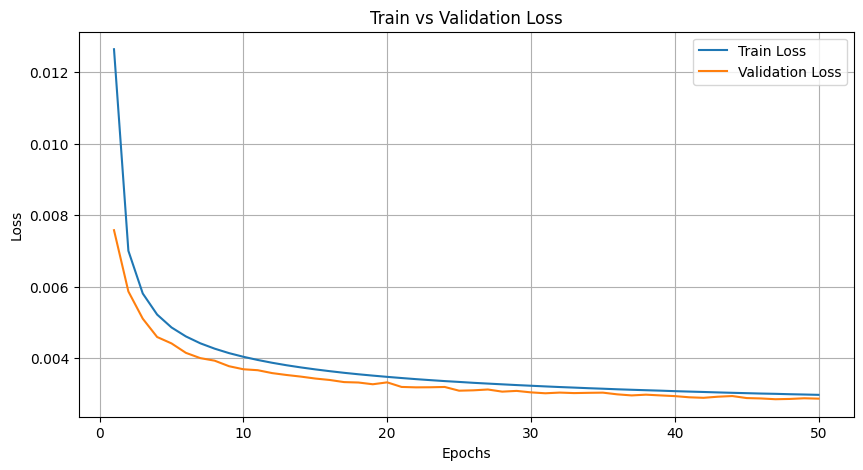

In [15]:
import matplotlib.pyplot as plt

# Plot train vs validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

In [16]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

def bhs_grade(errors):
    """
    Compute BHS (British Hypertension Society) accuracy grading.
    Grades are based on the percentage of errors within 5, 10, and 15 mmHg.
    """
    errors = np.abs(errors)
    total = len(errors)

    within_5 = np.sum(errors <= 5) / total * 100
    within_10 = np.sum(errors <= 10) / total * 100
    within_15 = np.sum(errors <= 15) / total * 100

    return within_5, within_10, within_15

# Model evaluation
model.eval()
test_preds = []
test_targets = []

with torch.no_grad():  # Disable gradient tracking
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred = model(X_batch)

        test_preds.append(y_pred.cpu().numpy())  # Store predictions
        test_targets.append(y_batch.cpu().numpy())  # Store ground truth

# Convert lists to NumPy arrays
test_preds = np.concatenate(test_preds, axis=0)
test_targets = np.concatenate(test_targets, axis=0)

# Reshape for inverse transform (assuming single feature per time step)
test_preds_reshaped = test_preds.reshape(-1, 1)
test_targets_reshaped = test_targets.reshape(-1, 1)

# Inverse transform using the same MinMaxScaler used for training
test_preds_unscaled = scaler_abp.inverse_transform(test_preds_reshaped)
test_targets_unscaled = scaler_abp.inverse_transform(test_targets_reshaped)

# Flatten to 1D arrays for evaluation
test_preds_unscaled = test_preds_unscaled.flatten()
test_targets_unscaled = test_targets_unscaled.flatten()

# Compute error metrics
mae = mean_absolute_error(test_targets_unscaled, test_preds_unscaled)
rmse = np.sqrt(mean_squared_error(test_targets_unscaled, test_preds_unscaled))

# Compute Mean ± SD error
errors = test_preds_unscaled - test_targets_unscaled
mean_error = np.mean(errors)
std_error = np.std(errors)

# Compute BHS grades
within_5, within_10, within_15 = bhs_grade(errors)

# Print results
print(f"Test MAE (mmHg): {mae:.4f}")
print(f"Test RMSE (mmHg): {rmse:.4f}")
print(f"Mean Error ± SD: {mean_error:.4f} ± {std_error:.4f} mmHg")
print(f"BHS Accuracy: ≤5 mmHg: {within_5:.2f}%, ≤10 mmHg: {within_10:.2f}%, ≤15 mmHg: {within_15:.2f}%")

Test MAE (mmHg): 4.3026
Test RMSE (mmHg): 6.3602
Mean Error ± SD: 0.0488 ± 6.3600 mmHg
BHS Accuracy: ≤5 mmHg: 70.52%, ≤10 mmHg: 91.53%, ≤15 mmHg: 96.94%


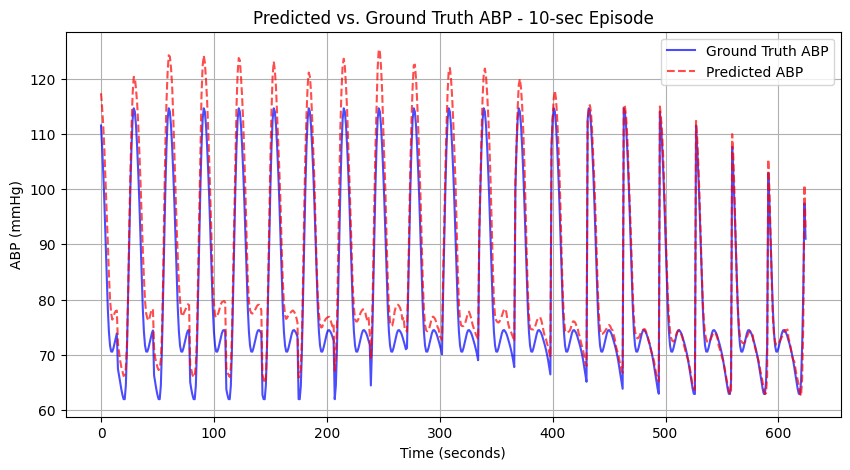

In [17]:
import matplotlib.pyplot as plt

# Select one 10-sec episode (first instance from test set)
episode_idx = 1  # Change this index to plot other 10-sec episodes
sequence_length = 625  # Number of time steps in a 10-sec episode

# Reshape the first 10-sec ABP prediction & ground truth
pred_abp_episode = test_preds_unscaled[episode_idx * sequence_length:(episode_idx + 1) * sequence_length]
true_abp_episode = test_targets_unscaled[episode_idx * sequence_length:(episode_idx + 1) * sequence_length]

# Create time axis (assuming 62.5 Hz sampling frequency)
#time_axis = np.arange(0, len(pred_abp_episode) / 62.5, 1 / 62.5)  # in seconds
data_points = np.arange(len(pred_abp_episode))

# Plot the predicted vs. ground truth ABP
plt.figure(figsize=(10, 5))
plt.plot(data_points, true_abp_episode, label="Ground Truth ABP", color='blue', alpha=0.7)
plt.plot(data_points, pred_abp_episode, label="Predicted ABP", color='red', linestyle="dashed", alpha=0.7)

plt.xlabel("Time (seconds)")
plt.ylabel("ABP (mmHg)")
plt.title("Predicted vs. Ground Truth ABP - 10-sec Episode")
plt.legend()
plt.grid()
plt.show()


In [18]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Initialize lists for SBP and DBP values
sbp_preds = []
dbp_preds = []
sbp_targets = []
dbp_targets = []

sequence_length = 625  # Number of time steps in a 10-sec episode
num_episodes = len(test_preds_unscaled) // sequence_length  # Total episodes

for i in range(num_episodes):
    # Extract the predicted & ground truth ABP for this 10-sec episode
    pred_abp_episode = test_preds_unscaled[i * sequence_length:(i + 1) * sequence_length]
    true_abp_episode = test_targets_unscaled[i * sequence_length:(i + 1) * sequence_length]

    # Extract SBP (max) and DBP (min) values
    sbp_preds.append(np.max(pred_abp_episode))
    dbp_preds.append(np.min(pred_abp_episode))
    sbp_targets.append(np.max(true_abp_episode))
    dbp_targets.append(np.min(true_abp_episode))

# Convert to NumPy arrays
sbp_preds = np.array(sbp_preds)
dbp_preds = np.array(dbp_preds)
sbp_targets = np.array(sbp_targets)
dbp_targets = np.array(dbp_targets)

# Compute MAE and RMSE for SBP
mae_sbp = mean_absolute_error(sbp_targets, sbp_preds)
rmse_sbp = np.sqrt(mean_squared_error(sbp_targets, sbp_preds))

# Compute Mean ± SD error for SBP
sbp_errors = sbp_preds - sbp_targets
sbp_mean_error = np.mean(sbp_errors)
sbp_std_error = np.std(sbp_errors)

# Compute BHS grades for SBP
sbp_within_5, sbp_within_10, sbp_within_15 = bhs_grade(sbp_errors)

# Compute MAE and RMSE for DBP
mae_dbp = mean_absolute_error(dbp_targets, dbp_preds)
rmse_dbp = np.sqrt(mean_squared_error(dbp_targets, dbp_preds))

# Compute Mean ± SD error for DBP
dbp_errors = dbp_preds - dbp_targets
dbp_mean_error = np.mean(dbp_errors)
dbp_std_error = np.std(dbp_errors)

# Compute BHS grades for DBP
dbp_within_5, dbp_within_10, dbp_within_15 = bhs_grade(dbp_errors)

# Print results
print(f"SBP - MAE: {mae_sbp:.2f} mmHg, RMSE: {rmse_sbp:.2f} mmHg")
print(f"SBP - Mean Error ± SD: {sbp_mean_error:.2f} ± {sbp_std_error:.2f} mmHg")
print(f"SBP - BHS Accuracy: ≤5 mmHg: {sbp_within_5:.2f}%, ≤10 mmHg: {sbp_within_10:.2f}%, ≤15 mmHg: {sbp_within_15:.2f}%")

print(f"DBP - MAE: {mae_dbp:.2f} mmHg, RMSE: {rmse_dbp:.2f} mmHg")
print(f"DBP - Mean Error ± SD: {dbp_mean_error:.2f} ± {dbp_std_error:.2f} mmHg")
print(f"DBP - BHS Accuracy: ≤5 mmHg: {dbp_within_5:.2f}%, ≤10 mmHg: {dbp_within_10:.2f}%, ≤15 mmHg: {dbp_within_15:.2f}%")


SBP - MAE: 6.80 mmHg, RMSE: 9.14 mmHg
SBP - Mean Error ± SD: 4.61 ± 7.89 mmHg
SBP - BHS Accuracy: ≤5 mmHg: 47.09%, ≤10 mmHg: 77.77%, ≤15 mmHg: 91.82%
DBP - MAE: 3.53 mmHg, RMSE: 5.35 mmHg
DBP - Mean Error ± SD: -2.34 ± 4.81 mmHg
DBP - BHS Accuracy: ≤5 mmHg: 78.45%, ≤10 mmHg: 95.55%, ≤15 mmHg: 98.37%
